In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gym import Env, spaces
from gym.utils import seeding

REGISTER_FLG=0

In [2]:
def categorical_sample(prob_n, np_random):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.rand()).argmax()


class DiscreteEnv(Env):

    """
    Has the following members
    - nS: number of states
    - nA: number of actions
    - P: transitions (*)
    - isd: initial state distribution (**)
    (*) dictionary dict of dicts of lists, where
      P[s][a] == [(probability, nextstate, reward, done), ...]
    (**) list or array of length nS
    """
    def __init__(self, nS, nA, P, isd):
        self.P = P
        self.isd = isd
        self.lastaction = None # for rendering
        self.nS = nS
        self.nA = nA

        self.action_space = spaces.Discrete(self.nA)
        self.observation_space = spaces.Discrete(self.nS)

        self.seed()
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction=None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction = None
        return self.s

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d= transitions[i]
        self.s = s
        self.lastaction = a
        return (s, r, d, {"prob" : p})

In [3]:
import sys
from contextlib import closing

import numpy as np
from six import StringIO, b

from gym import utils
from gym.envs.toy_text import discrete

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
}


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # BFS to check that it's a valid path.
    def is_valid(arr, r=0, c=0):
        if arr[r][c] == 'G':
            return True

        tmp = arr[r][c]
        arr[r][c] = "#"

        # Recursively check in all four directions.
        directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        for x, y in directions:
            r_new = r + x
            c_new = c + y
            if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                continue

            if arr[r_new][c_new] not in '#H':
                if is_valid(arr, r_new, c_new):
                    arr[r][c] = tmp
                    return True

        arr[r][c] = tmp
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4",is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel() #initial state distribution
        isd /= isd.sum()

        P = {s : {a : [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row*ncol + col
        
        def inc(row, col, a):
            if a == LEFT:
                col = max(col-1,0)
            elif a == DOWN:
                row = min(row+1,nrow-1)
            elif a == RIGHT:
                col = min(col+1,ncol-1)
            elif a == UP:
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'GH':
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a-1)%4, a, (a+1)%4]:
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow, newcol]
                                done = bytes(newletter) in b'GH'
                                rew = float(newletter == b'G')
                                li.append((1.0/3.0, newstate, rew, done))
                        else:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            li.append((1.0, newstate, rew, done))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()

In [4]:
import numpy as np
class ELAgent():

    def __init__(self, epsilon):
        self.Q = {}
        self.epsilon = epsilon
        self.reward_log = []

    def policy(self, s, actions):
        if np.random.random() < self.epsilon:
            return np.random.randint(len(actions))
        else:
            if s in self.Q and sum(self.Q[s]) != 0:
                return np.argmax(self.Q[s])
            else:
                return np.random.randint(len(actions))

    def init_log(self):
        self.reward_log = []

    def log(self, reward):
        self.reward_log.append(reward)

    def show_reward_log(self, interval=50, episode=-1):
        if episode > 0:
            rewards = self.reward_log[-interval:]
            mean = np.round(np.mean(rewards), 3)
            std = np.round(np.std(rewards), 3)
            #print("At Episode {} average reward is {} (+/-{}).".format(episode, mean, std))
        else:
            indices = list(range(0, len(self.reward_log), interval))
            means = []
            stds = []
            for i in indices:
                rewards = self.reward_log[i:(i + interval)]
                means.append(np.mean(rewards))
                stds.append(np.std(rewards))
            means = np.array(means)
            stds = np.array(stds)
            plt.figure()
            plt.title("Reward History")
            plt.grid()
            plt.fill_between(indices, means - stds, means + stds,
                             alpha=0.1, color="g")
            plt.plot(indices, means, "-", color="g",
                     label="Rewards for each {} episode".format(interval))
            plt.legend(loc="best")
            plt.show()
        


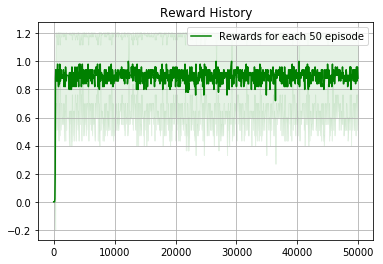

In [5]:
from collections import defaultdict
import gym
import matplotlib.pyplot as plt

class QLearningAgent(ELAgent):

    def __init__(self, epsilon=0.1):
        super().__init__(epsilon)

    def learn(self, env, episode_count=1000, gamma=0.9,
              learning_rate=0.1, render=False, report_interval=50):
        self.init_log()
        actions = list(range(env.action_space.n))
        self.Q = defaultdict(lambda: [0] * len(actions))#n_stateの4方向actionの価値
        for e in range(episode_count):
            s = env.reset()
            done = False
            while not done:
                if render:
                    env.render()
                a = self.policy(s, actions)
                n_state, reward, done, info = env.step(a) #ランダムにaをスリップ
                #print(n_state,reward,done,info)
                gain = reward + gamma * max(self.Q[n_state])
                estimated = self.Q[s][a]
                self.Q[s][a] += learning_rate * (gain - estimated)
                s = n_state

            else:
                self.log(reward)
        #print(self.Q)


def train():
    agent = QLearningAgent()
    env = gym.make("FrozenLakeEasy-v0") #gym
    agent.learn(env, episode_count=50000)
    agent.show_reward_log()

from gym.envs.registration import register
if REGISTER_FLG==0:
    register(id="FrozenLakeEasy-v0", entry_point=FrozenLakeEnv,kwargs={"is_slippery": False})    
    REGISTER_FLG+=1
    
if __name__ == "__main__":
    train()

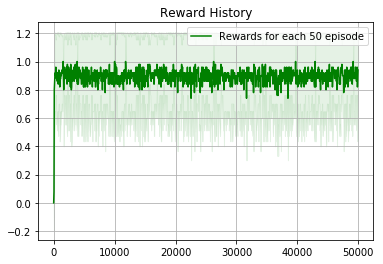

In [6]:
import math
class MonteCarloAgent(ELAgent):

    def __init__(self, epsilon=0.1):
        super().__init__(epsilon)

    def learn(self, env, episode_count=1000, gamma=0.9,
              render=False, report_interval=50):
        self.init_log()
        actions = list(range(env.action_space.n))
        self.Q = defaultdict(lambda: [0] * len(actions))
        N = defaultdict(lambda: [0] * len(actions))

        for e in range(episode_count):
            s = env.reset()
            done = False
            # Play until the end of episode.
            experience = []
            while not done:
                if render:
                    env.render()
                a = self.policy(s, actions)
                n_state, reward, done, info = env.step(a)
                experience.append({"state": s, "action": a, "reward": reward})
                s = n_state
            else:
                self.log(reward)

            # Evaluate each state, action.
            for i, x in enumerate(experience):
                s, a = x["state"], x["action"]

                # Calculate discounted future reward of s.
                G, t = 0, 0
                for j in range(i, len(experience)):
                    G += math.pow(gamma, t) * experience[j]["reward"]
                    t += 1

                N[s][a] += 1  # count of s, a pair
                alpha = 1 / N[s][a]
                self.Q[s][a] += alpha * (G - self.Q[s][a])

            if e != 0 and e % report_interval == 0:
                self.show_reward_log(episode=e)


def train():
    agent = MonteCarloAgent(epsilon=0.1)
    env = gym.make("FrozenLakeEasy-v0")
    agent.learn(env, episode_count=50000)
    agent.show_reward_log()


if __name__ == "__main__":
    train()

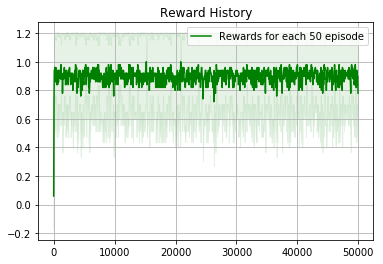

In [7]:
class SARSAAgent(ELAgent):

    def __init__(self, epsilon=0.1):
        super().__init__(epsilon)

    def learn(self, env, episode_count=1000, gamma=0.9,
              learning_rate=0.1, render=False, report_interval=50):
        self.init_log()
        actions = list(range(env.action_space.n))
        self.Q = defaultdict(lambda: [0] * len(actions))
        for e in range(episode_count):
            s = env.reset()
            done = False
            a = self.policy(s, actions)
            while not done:
                if render:
                    env.render()
                n_state, reward, done, info = env.step(a)

                n_action = self.policy(n_state, actions)  # On-policy
                gain = reward + gamma * self.Q[n_state][n_action]
                estimated = self.Q[s][a]
                self.Q[s][a] += learning_rate * (gain - estimated)
                s = n_state
                a = n_action
            else:
                self.log(reward)

            if e != 0 and e % report_interval == 0:
                self.show_reward_log(episode=e)


def train():
    agent = SARSAAgent()
    env = gym.make("FrozenLakeEasy-v0")
    agent.learn(env, episode_count=50000)
    agent.show_reward_log()


if __name__ == "__main__":
    train()


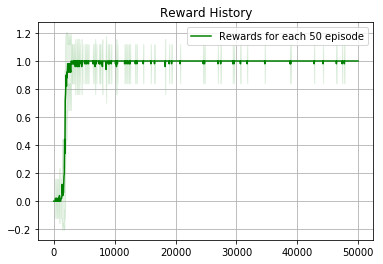

In [8]:
class Actor(ELAgent):

    def __init__(self, env):
        super().__init__(epsilon=-1)
        nrow = env.observation_space.n
        ncol = env.action_space.n
        self.actions = list(range(env.action_space.n))
        self.Q = np.random.uniform(0, 1, nrow * ncol).reshape((nrow, ncol))

    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def policy(self, s):
        a = np.random.choice(self.actions, 1,
                             p=self.softmax(self.Q[s]))
        return a[0]


class Critic():

    def __init__(self, env):
        states = env.observation_space.n
        self.V = np.zeros(states)


class ActorCritic():

    def __init__(self, actor_class, critic_class):
        self.actor_class = actor_class
        self.critic_class = critic_class

    def train(self, env, episode_count=1000, gamma=0.9,
              learning_rate=0.1, render=False, report_interval=50):
        actor = self.actor_class(env)
        critic = self.critic_class(env)

        actor.init_log()
        for e in range(episode_count):
            s = env.reset()
            done = False
            while not done:
                if render:
                    env.render()
                a = actor.policy(s)
                n_state, reward, done, info = env.step(a)

                gain = reward + gamma * critic.V[n_state]
                estimated = critic.V[s]
                td = gain - estimated
                actor.Q[s][a] += learning_rate * td
                critic.V[s] += learning_rate * td
                s = n_state

            else:
                actor.log(reward)

            if e != 0 and e % report_interval == 0:
                actor.show_reward_log(episode=e)

        return actor, critic


def train():
    trainer = ActorCritic(Actor, Critic)
    env = gym.make("FrozenLakeEasy-v0")
    actor, critic = trainer.train(env, episode_count=50000)
    actor.show_reward_log()


if __name__ == "__main__":
    train()
